#### This notebook is to test whether UIUC and NRL are using the same noise generation algorithm.

In [201]:
%pylab inline
from Scientific.IO.NetCDF import NetCDFFile as Dataset
from datetime import datetime, timedelta
from pyglow import pyglow
from mpl_toolkits.basemap import Basemap
import os
import glob
from scipy.interpolate import griddata
import subprocess
import ICON
import sys
import time as time_module
from IPython.display import display, clear_output
from scipy import interpolate
import netCDF4
import MIGHTI_L2
import MIGHTI

import sys
import time as time_mod
from IPython.display import display, clear_output

# Change matplotlib defaults
matplotlib.rcParams['savefig.dpi'] = 150
matplotlib.rcParams['figure.figsize'] = (4,3)
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['xtick.labelsize'] = 'small'
matplotlib.rcParams['ytick.labelsize'] = 'small'
#matplotlib.rcParams['legend.fancybox'] = 'True'
matplotlib.rcParams['legend.fontsize'] = 'small'
matplotlib.rcParams['legend.numpoints'] = 1

plt.style.use('dark_background')
matplotlib.rcParams['axes.grid'] = False


Populating the interactive namespace from numpy and matplotlib


# Parameters

In [185]:
emission_color = 'red'

emissions =  MIGHTI.get_emission_constants()
params = MIGHTI.get_instrument_constants()

params['exptime'] =        30.   # sec
params['lam'] =            emissions[emission_color]['lam']
params['mass'] =           emissions[emission_color]['mass']
startpath = 4.62
endpath = 5.50
params['nx'] = 396
params['darkcurrent'] = 0.0
params['readnoise'] = 0.0

#params['etendue'] = 0.0074*1e-4
params['etendue'] = 0.0495*1e-4

'''
From Kenneth:

FrqGreen = 19.6          ; fringe frequency of green line [fringes per grating width]
FrqRed   = 45.3           ; fringe frequency of red line [fringes per grating width]
sigmaRed = 1./630.0e-7           ; wavenumber red line [cm-1]
sigmaGreen = 1./557.7e-7         ; wavenumber green line [cm-1]
startpath = 4.62
endpath = 5.50
InstVisRed = 0.70 - 0.03 * dindgen(npixel)/(npixel-1)
InstVisGrn = 0.55 - 0.03 * dindgen(npixel)/(npixel-1)
optEffG = .1389
optEffR = .1876
'''
if emission_color == 'red':
    params['fringe_contrast'] = 0.70
    params['opteff'] = 0.1876
    params['frq'] = 45.3
else:
    params['fringe_contrast'] = 0.55
    params['opteff'] = 0.1389
    params['frq'] = 19.6

# Generate L0 image

In [186]:
england_fn = '/rdata/airglow/MIGHTI/verification_simulations/AB_20160322/England_raw/ICON_MIGHTI_A_ray_UT_345.000.nc'

ncfile = Dataset(england_fn,'r')
vs = ncfile.variables.keys()

ray_length = ncfile.variables['MIGHTI_RAY_LENGTH_KM'][0]
emission_along_ray_r = ncfile.variables['MIGHTI_%sLINE_ALONG_RAY_R' % emission_color.upper()][0,:,:,:]
winds_along_ray = ncfile.variables['MIGHTI_LOS_WINDS_ALONG_RAY'][0,:,:,:]
temps_along_ray = ncfile.variables['MIGHTI_TEMPERATURES_ALONG_RAY'][0,:,:,:]
alts_along_ray_start = ncfile.variables['MIGHTI_WGS84_ALTITUDES_ALONG_RAY_START'][0,:,:,:]
alts_along_ray_end = ncfile.variables['MIGHTI_WGS84_ALTITUDES_ALONG_RAY_END'][0,:,:,:]
lats_along_ray_start = ncfile.variables['MIGHTI_WGS84_LATITUDES_ALONG_RAY_START'][0,:,:,:]
lats_along_ray_end = ncfile.variables['MIGHTI_WGS84_LATITUDES_ALONG_RAY_END'][0,:,:,:]
lons_along_ray_start = ncfile.variables['MIGHTI_WGS84_LONGITUDES_ALONG_RAY_START'][0,:,:,:]
lons_along_ray_end = ncfile.variables['MIGHTI_WGS84_LONGITUDES_ALONG_RAY_END'][0,:,:,:]
tang_point_along_ray_start = ncfile.variables['MIGHTI_TANGENT_POINT_ALONG_RAY_START'][0,:,:] # integer index
tang_point_along_ray_end  = ncfile.variables['MIGHTI_TANGENT_POINT_ALONG_RAY_END'][0,:,:] # integer index
tang_alt_start = ncfile.variables['MIGHTI_TANGENT_ALTITUDES_START'][0,:,:]
tang_alt_end = ncfile.variables['MIGHTI_TANGENT_ALTITUDES_END'][0,:,:]
tang_lat_start = ncfile.variables['MIGHTI_TANGENT_LATITUDES_START'][0,:,:]
tang_lat_end = ncfile.variables['MIGHTI_TANGENT_LATITUDES_END'][0,:,:]
tang_lon_start = ncfile.variables['MIGHTI_TANGENT_LONGITUDES_START'][0,:,:]
tang_lon_end = ncfile.variables['MIGHTI_TANGENT_LONGITUDES_END'][0,:,:]
#icon_alt_start = ncfile.variables['ICON_ALTITUDE_START'][0,0,0,0]
#icon_alt_end = ncfile.variables['ICON_ALTITUDE_END'][0,0,0,0]
icon_alt_start = ncfile.variables['ICON_ALTITUDE_START'][0,]
icon_alt_end = ncfile.variables['ICON_ALTITUDE_END'][0,]
icon_lat_start = ncfile.variables['ICON_LATITUDE_START'][0,] 
icon_lat_end = ncfile.variables['ICON_LATITUDE_END'][0,] 
icon_lon_start = ncfile.variables['ICON_LONGITUDE_START'][0,]
icon_lon_end = ncfile.variables['ICON_LONGITUDE_END'][0,] 
icon_ecef_ram_vector_start = ncfile.variables['ICON_ECEF_RAM_VECTOR_START'][0,:]
icon_ecef_ram_vector_end = ncfile.variables['ICON_ECEF_RAM_VECTOR_END'][0,:]
icon_velocity_start = ncfile.variables['ICON_VELOCITY_START'][0]*1000 # convert from km/s to m/s
icon_velocity_end = ncfile.variables['ICON_VELOCITY_END'][0]*1000 # convert from km/s to m/s
mighti_sza = ncfile.variables['MIGHTI_SZA'][0,:,:,:] # 1000 x 101 x 3

mighti_ecef_vectors_start = ncfile.variables['MIGHTI_ECEF_VECTORS_START'][0,:,:,:]
mighti_ecef_vectors_end = ncfile.variables['MIGHTI_ECEF_VECTORS_END'][0,:,:,:]
mighti_horizontal_component = ncfile.variables['MIGHTI_HORIZONTAL_COMPONENT'][0,:,:,:]
mighti_corotation_vel = ncfile.variables['MIGHTI_COROTATION_VEL'][0,:,:,:]
# Hack to fix a nan issue
mighti_horizontal_component[isnan(mighti_horizontal_component)] = 1.0 # shouldn't make a difference


In [187]:
nx = params['nx']
ny = shape(winds_along_ray)[1] # number of rows of interferogram
nk = shape(winds_along_ray)[0] # number of steps along ray

tang_alts = tang_alt_start[:,j]

Iraw = np.zeros((ny,nx))

for i in range(ny):
    for k in range(nk):

        amp = emission_along_ray_r[k,i,j]
        vel = winds_along_ray[k,i,j]
        temp = temps_along_ray[k,i,j]
            
        alt = alts_along_ray_start[k,i,j]

        params['V'] = vel
        params['T'] = temp
        params['I'] = amp

        ccdslice = MIGHTI.interferogram(params)

        Iraw[i,:] += ccdslice
        


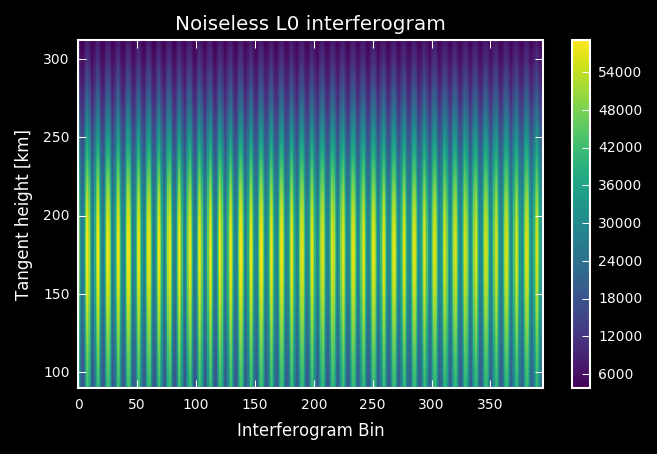

In [188]:
figure(figsize=(5,3))
X,TANH = meshgrid(arange(nx),tang_alts)
pcolormesh(X,TANH, Iraw,cmap='viridis')
axis('tight')
xlabel('Interferogram Bin')
ylabel('Tangent height [km]')
title('Noiseless L0 interferogram')
colorbar()

In [189]:
#Inoisy = MIGHTI.add_noise(Iraw, params) # make sure units are right
Inoisy = Iraw.copy()

# Filter (L1 processing)

In [190]:
Ir = zeros(shape(Inoisy))
Ii = zeros(shape(Inoisy))
for i in range(shape(Inoisy)[0]):
    # Filter with Hann window (in frequency) surrounding the peak
    f = Inoisy[i,:]
    F = np.fft.fft(f)
    N = len(F)
    n = arange(N)
    # Create filter as per Ken Marr's email 2013/10/29
    peaki = abs(F[5:int(floor(N/2))]).argmax() + 5
    width1 = 20 # width of Hann window
    width2 = 5 # width of plateau
    if peaki-width1/2-(width2-1)/2 < 0: # this row is probably mostly noise
        # Just do something as a placeholder
        peaki = width1/2 + (width2-1)/2 + 1
    hann = np.hanning(width1)
    # Create full filter
    H = hstack((zeros(peaki-width1/2-(width2-1)/2), 
                hann[:width1/2], 
                ones(width2), 
                hann[width1/2:], 
                zeros(N - peaki - width1/2 - (width2-1)/2 - 1)))
    ap = hanning(N)
    f = f - f.mean()
    #fap = f*ap
    fap = f.copy()
    
    F = np.fft.fft(fap)
    F2 = F * H
    f2 = np.fft.ifft(F2)
    Ir[i,:] = np.real(f2)
    Ii[i,:] = np.imag(f2)
    
I = Ir + 1j*Ii

(26, 66)

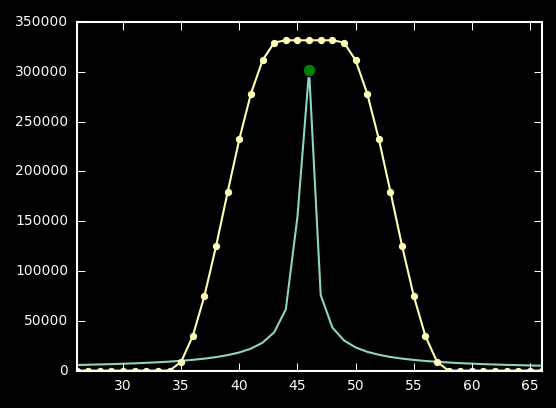

In [191]:
plot(abs(F))
plot(peaki, abs(F)[peaki],'go')
plot(abs(F)[peaki]*1.1*H,'.-')

xlim(peaki-20,peaki+20)

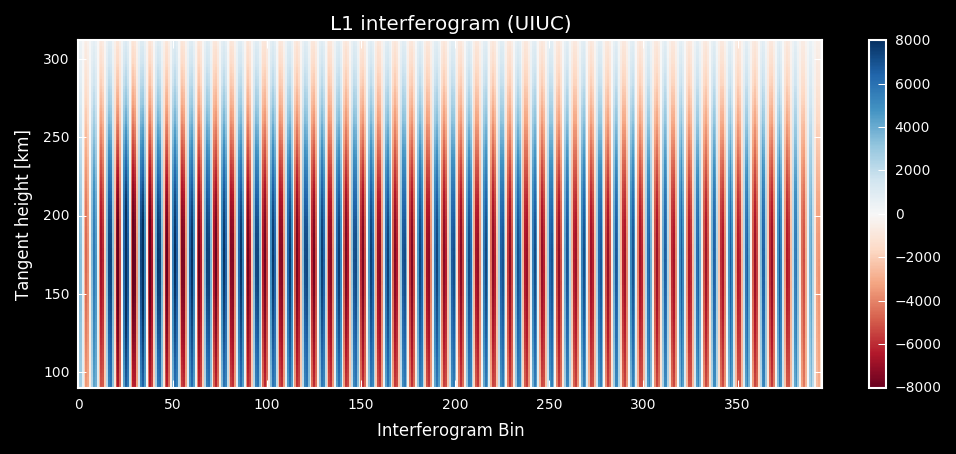

In [192]:
figure(figsize=(8,3))
X,TANH = meshgrid(arange(nx),tang_alts)
pcolormesh(X,TANH, Ir,cmap='RdBu')
axis('tight')
xlabel('Interferogram Bin')
ylabel('Tangent height [km]')
title('L1 interferogram (UIUC)')
m = abs(Ir[:,50:-50]).max()
clim((-m,m))
colorbar()

In [208]:
marr_fn = '/rdata/airglow/MIGHTI/verification_simulations/precision_20160712/L1/image_v0035.nc'
marr_f = netCDF4.Dataset(marr_fn)
marr_f.variables.keys()
envelope_marr_noiseless = marr_f['%s_ENVELOPE_NOISELESS' % emission_color.upper()][:]
phase_marr_noiseless    = marr_f['%s_PHASE_NOISELESS' % emission_color.upper()][:]
I_marr_noiseless = envelope_marr_noiseless * exp(1j*phase_marr_noiseless)

#marr_f.variables.keys()

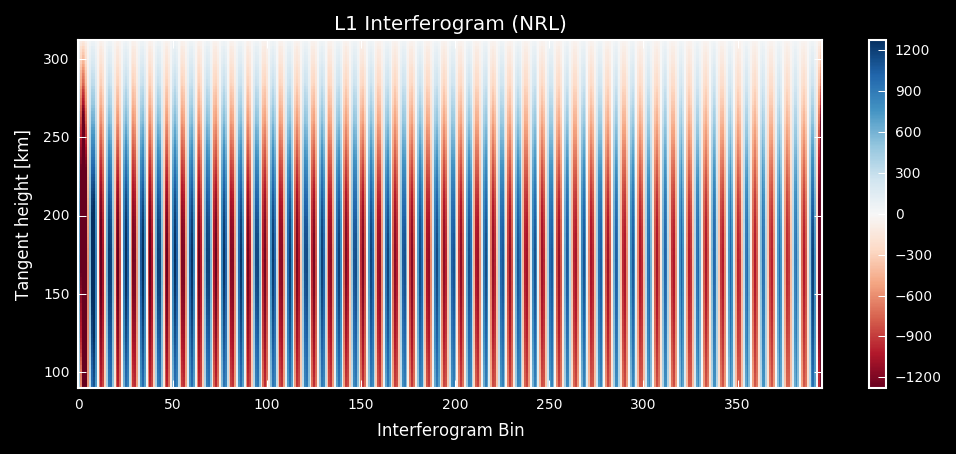

In [194]:
figure(figsize=(8,3))
X,TANH = meshgrid(arange(nx),tang_alts)
pcolormesh(X,TANH, real(I_marr_noiseless),cmap='RdBu')
axis('tight')
xlabel('Interferogram Bin')
ylabel('Tangent height [km]')
title('L1 Interferogram (NRL)')
colorbar()
m = abs(I_marr_noiseless[:,50:-50]).max()
clim((-m,m))

6.51699560061


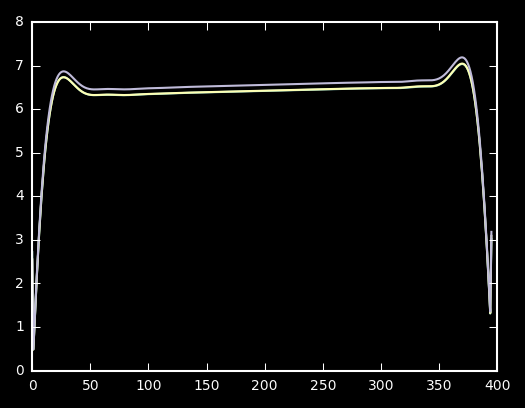

In [195]:
d = abs(I)/abs(I_marr_noiseless)
plot(d[10,:])
plot(d[35,:])
plot(d[60,:])
print median(d)

In [196]:
# Copied from EnglandIntf_build.pro 
ApertureArea = 3.078 * 3.078    # cm2
ConeAngle1 = 3.22/180*pi
ConeAngle2 = 5.74/180*pi  
dayFact = 0.15 # 1 or 0.15? night or day
nalts = 101
SliceAOmega = ApertureArea * sin(ConeAngle1) * sin(ConeAngle2) / (nalts) * dayFact
print SliceAOmega*nalts

0.00798354265475


# Other old stuff:

In [197]:
####### Pass 1: Extract empirical uncertainties from Marr files ########
L1_fns = glob.glob('/rdata/airglow/MIGHTI/verification_simulations/precision_20160712/L1/image_v*.nc')
params_L2 = MIGHTI_L2.get_instrument_constants(emission_color, startpath, endpath)
Nignore = 50
M = ny
N = len(L1_fns)
phase_L1 = zeros((M,N))
amp_L1   = zeros((M,N))
for n in range(N):
    L1_fn = L1_fns[n]
    L1_dict = MIGHTI_L2.level1_to_dict(L1_fn, emission_color)
    Iraw = L1_dict['I_amp']*np.exp(1j*L1_dict['I_phase'])

    for i_row in range(M):
        phase_L1[i_row, n] = MIGHTI_L2.extract_phase_from_row(Iraw[i_row,:], params_L2['zero_phase'], params_L2['phase_offset'], Nignore)
        amp_L1[i_row, n]   = abs(Iraw[i_row, Nignore:-Nignore]).sum()
        
    if mod(n,10)==0:
        clear_output(wait=True)
        time_module.sleep(0.01)
        print n
        sys.stdout.flush()

sigma_phase_L1_NRL = array([0.5*(prctile(phase_L1[m,:],84) - prctile(phase_L1[m,:],16)) for m in range(M)])
sigma_amp_L1_NRL   = array([0.5*(prctile(amp_L1[m,:],84) -   prctile(amp_L1[m,:],16)) for m in range(M)])

320


In [198]:
####### Pass 2: Extract empirical uncertainties from my methodology #########
phase_L1 = zeros((M,N))
amp_L1   = zeros((M,N))

for nn in range(N):
    Inoisy = MIGHTI.add_noise(Iraw, params) # make sure units are right
    Ir = zeros(shape(Inoisy))
    Ii = zeros(shape(Inoisy))
    for i in range(shape(Inoisy)[0]):
        # Filter with Hann window (in frequency) surrounding the peak
        f = Inoisy[i,:]
        F = np.fft.fft(f)
        Nf = len(F)
        n = arange(Nf)
        # Create filter as per Ken Marr's email 2013/10/29
        peaki = abs(F[5:int(floor(Nf/2))]).argmax() + 5
        width1 = 20 # width of Hann window
        width2 = 5 # width of plateau
        if peaki-width1/2-(width2-1)/2 < 0: # this row is probably mostly noise
            # Just do something as a placeholder
            peaki = width1/2 + (width2-1)/2 + 1
        hann = np.hanning(width1)
        # Create full filter
        H = hstack((zeros(peaki-width1/2-(width2-1)/2), 
                    hann[:width1/2], 
                    ones(width2), 
                    hann[width1/2:], 
                    zeros(Nf - peaki - width1/2 - (width2-1)/2 - 1)))
        ap = hanning(Nf)
        f = f - f.mean()
        #fap = f*ap
        fap = f.copy()

        F = np.fft.fft(fap)
        F2 = F * H
        f2 = np.fft.ifft(F2)
        Ir[i,:] = np.real(f2)
        Ii[i,:] = np.imag(f2)

    I = Ir + 1j*Ii
    
    for i_row in range(M):
        phase_L1[i_row, nn] = MIGHTI_L2.extract_phase_from_row(I[i_row,:], params_L2['zero_phase'], params_L2['phase_offset'], Nignore)
        amp_L1[i_row, nn]   = abs(I[i_row, Nignore:-Nignore]).sum()
        
sigma_phase_L1_UIUC = array([0.5*(prctile(phase_L1[m,:],84) - prctile(phase_L1[m,:],16)) for m in range(M)])
sigma_amp_L1_UIUC   = array([0.5*(prctile(amp_L1[m,:],84) -   prctile(amp_L1[m,:],16)) for m in range(M)])

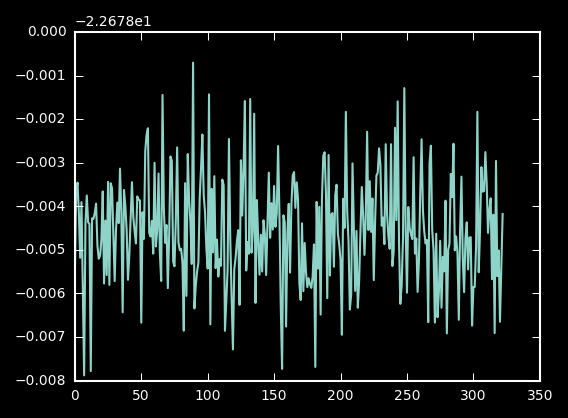

In [199]:
plot(phase_L1[10,:])

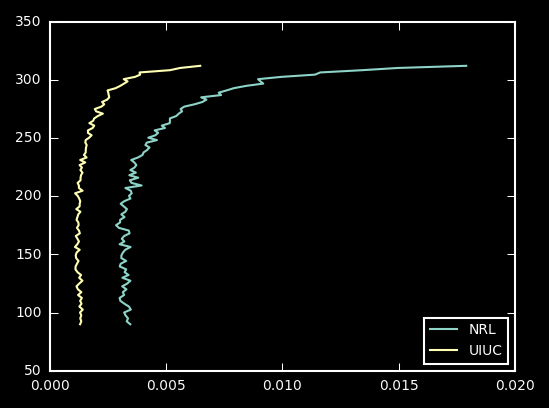

In [200]:
plot( sigma_phase_L1_NRL, tang_alts, label='NRL')
plot( sigma_phase_L1_UIUC, tang_alts, label='UIUC')
xlim((0,0.02))
legend(loc='best')

In [207]:
# Testbed: run a L1 UIUC and L1 NRL file
reload(MIGHTI_L2)
L1_dict = MIGHTI_L2.level1_uiuc_to_dict('/rdata/airglow/MIGHTI/verification_simulations/AB_20160725/UIUCL1/ICON_MIGHTI_A_ray_UT_1035.00.npz')
success = MIGHTI_L2.level1_dict_to_level21(L1_dict, '/home/bhardin2/MIGHTI/example_level21.npz')

L1_dict = MIGHTI_L2.level1_to_dict('/rdata/airglow/MIGHTI/verification_simulations/precision_20160712/L1/image_v0006.nc', 'red')
success = MIGHTI_L2.level1_dict_to_level21(L1_dict, '/home/bhardin2/MIGHTI/example_level21.npz')
